# Process Data using MediaPipe Pose Extraction

This contains our code to extract the WLASL100 and process the videos into numpy arrays and glosses into integer labels

References:
* https://www.kaggle.com/code/abd0kamel/mutemotion-wlasl-translation-model
* https://openaccess.thecvf.com/content/WACV2022W/HADCV/papers/Bohacek_Sign_Pose-Based_Transformer_for_Word-Level_Sign_Language_Recognition_WACVW_2022_paper.pdf

## Import and Install Libraries

* Import Mediapipe for landmark extraction
* Define global variables

In [10]:
%pip install -q mediapipe==0.10.7

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink

In [12]:
'''
Modify variables for respective computer
Rena: 'wlasl
Esther: '/Users/esther/Downloads/archive'
'''
base_path = 'wlasl'

'''
n determines number of glosses we wish to extract
'''
n = 100

## Define landmark extraction functions

We use Mediapipe to extract the following landmarks:
* Hands: 42 (21 per hand)
* Pose: 7 for the face (eyes, nose, ends of mouth), 4 for the upper body (shoulders, elbows)

We only extract (x,y) coordinates and disregard the z coordinate

Total: 53 landmarks each with coordinates (x,y) = 106 features per frame

In [21]:
# import enumerated types of the landmarks
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.hands import HandLandmark

In [28]:
# import enumerated types of the landmarks
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.hands import HandLandmark

# define which landmarks from pose we want to keep
filtered_pose = [
  PoseLandmark.NOSE,
  PoseLandmark.LEFT_EYE_INNER,
  PoseLandmark.RIGHT_EYE_INNER,
  PoseLandmark.LEFT_EYE_OUTER,
  PoseLandmark.RIGHT_EYE_OUTER,
  PoseLandmark.MOUTH_LEFT,
  PoseLandmark.MOUTH_RIGHT,
  PoseLandmark.LEFT_SHOULDER,
  PoseLandmark.RIGHT_SHOULDER,
  PoseLandmark.LEFT_WRIST,
  PoseLandmark.RIGHT_WRIST,
  PoseLandmark.LEFT_ELBOW,
  PoseLandmark.RIGHT_ELBOW,
]

HAND_NUM = len(HandLandmark) # we use all hand landmarks
POSE_NUM = len(filtered_pose)

print(f'total landmarks = {2 * HAND_NUM + POSE_NUM}')

total landmarks = 55


In [33]:
# Initialize MediaPipe Models
hands = mp.solutions.hands.Hands()
pose = mp.solutions.pose.Pose()
face = mp.solutions.face_detection.FaceDetection()

'''
A function to exract the hands, and pose landmarks given a single frame
Params:
    frame: a (image height, image width, (R,G,B) channel values) shape numpy array 
    representing an image in RGB colors
Returns:
    a (2 * NAND_NUM + POSE_NUM, (x,y) coordinates) numpy array containing the relevant
    landmarks of the frame
'''
# For a given (single) frame, extract hands, pose, and face landmarks
def get_frame_landmarks(frame):
    
    # Initialize array to store x,y coordinates of the detected landmarks (hands and pose)
    all_landmarks = np.zeros((2 * HAND_NUM + POSE_NUM, 2))
    
    def get_hands(frame):
        # Applies hand detection and landmark estimation model to the frame and returns the results
        # Result includes detected hand landmarks
        results_hands = hands.process(frame)
        # Checks if any hand landmarks were detected in the frame
        if results_hands.multi_hand_landmarks:
            # If the list is not empty
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                # Checks if the current hand being processed is classified as right hand
                if results_hands.multi_handedness[i].classification[0].index == 0: 
                    # Updates first 'HAND_NUM' rows of all_landmarks array with x,y coordinates of detected right hand landmarks
                    all_landmarks[:HAND_NUM, :] = np.array(
                        [(lm.x, lm.y) for lm in hand_landmarks.landmark])
                else:
                    # Repeat for left hand
                    all_landmarks[HAND_NUM:2*HAND_NUM, :] = np.array(
                        [(lm.x, lm.y) for lm in hand_landmarks.landmark]) # left
    
    # Get the landmarks for the upper body and store in the array
    def get_pose(frame):
        results_pose = pose.process(frame)
        if results_pose.pose_landmarks:
            all_landmarks[2*HAND_NUM:2*HAND_NUM+POSE_NUM, :] = np.array(
                [(lm.x, lm.y) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]
    
    def get_face(frame):
        results_face = face.process(frame)
        if results_face.detections:
            all_landmarks[2*HAND_NUM+POSE_NUM:, :] = np.array(
                [(lm.x, lm.y) for lm in results_face.detections])
            print(results_face.detections)
    
    # ThreadPoolExecutor implemented to run the modules in parallel
    # Improve efficiency of processing video frames
    with ThreadPoolExecutor(max_workers=3) as executor:
        executor.submit(get_hands, frame)
        executor.submit(get_pose, frame)
        #executor.submit(get_face, frame)

    return all_landmarks

In [32]:
'''
A function to get the landmarks for all frames in a video
Params:
    video_path: a string of the stored path of the video
    start_frame: an int representing the first frame of video where the signing starts
    end_frame: an int representing the last frame of the video where the signing ends
Returns:
    a (end_frame-start_frame+1, 2 * NAND_NUM + POSE_NUM, (x,y) coordinates) numpy array
    containing the relevant landmarks of each frame in a video
'''
def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)
    
    # If the starting is 0
    if start_frame <= 1:
        start_frame = 1
        
    # If the video is precropped - adjust start and end to include the entire video
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    # If the final frame was not given (-1) - set to total number of frames in the video
    if end_frame < 0: 
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize array to store landmakrs for all frames
    num_landmarks = HAND_NUM * 2 + POSE_NUM
    all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 2))
    frame_index = 1
    
    # Check if video capture object is stil valid and frame is within the desired range
    while cap.isOpened() and frame_index <= end_frame:
        # Read next frame from the video
        # ret - boolean to indicate if the frame was successfully read
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            # Make the frame read-only - optimize process
            frame.flags.writeable = False
            # Convert frame from BGR color format to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Extract landmakrs from current frame
            frame_landmarks = get_frame_landmarks(frame)
            # Store all the landmarks in the array
            all_frame_landmarks[frame_index - start_frame] = frame_landmarks

        frame_index += 1

    # Release video capture object
    cap.release()
    # Rest MediaPipe models to initial state - clear stored state or information
    hands.reset()
    pose.reset()
    face.reset()
    
    return all_frame_landmarks

### Visualize landmarks on an example image
Iterate through the landmarks of each frame in the video and rewrites the frame with marked landmarks

Outputs the new frames as a video (sequence of the frames)

In [31]:
'''
A function to draw the landmarks on an image
Params:
    input_path: a string of the path of the image to draw landmarks on
    output_path: a string of the path to write the image with landmarks on it
    video_landmarks: a (frames, 2 * NAND_NUM + POSE_NUM, (x,y) coordinates) numpy array containing the
        landmarks of the videos
    start_frame: an int representing the first frame of video where the signing starts
    end_frame: an int representing the last frame of the video where the signing ends
Returns:
    None
'''
def draw_landmarks(input_path, output_path, video_landmarks, start_frame=1, end_frame=-1):
    # Set up video capture object to read from input path and video write object to write processed frames to output path
    # Frame rate, width, height of output videos are matched to input video's properties
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Adjust starting and ending frame
    if start_frame <= 1:
        start_frame = 1
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if end_frame < 0:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_index = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_index >= start_frame and frame_index <= end_frame:
            # Extract the landmarks for current frame and scale the coordinates to match the frame's dimensions
            frame_landmarks = video_landmarks[frame_index - start_frame]
            landmarks = [(int(x * width), int(y * height)) for x, y in frame_landmarks]
            # For each landmark, circle is drawn on the frame
            for x, y in landmarks:
                cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
            # Processed frame with landmarks written to output file
            out.write(frame)
        else:
            # out.write(frame) # Enable if you want the full video
            pass
        frame_index += 1

    cap.release()
    out.release()

### Example visualization of extracting landmarks

Use an image online to test
* get_frame_landmarks
* get_video_landmarks
* draw_landmarks

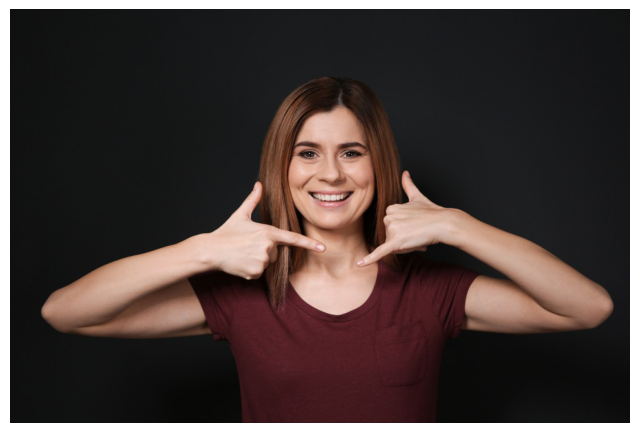

In [34]:
import requests
from PIL import Image
from io import BytesIO

image_url = 'https://www.memorialhearing.com/wp-content/uploads/2021/11/The-Role-of-Sign-Language-Interpreters-Memorial-Hearing-1.jpg'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

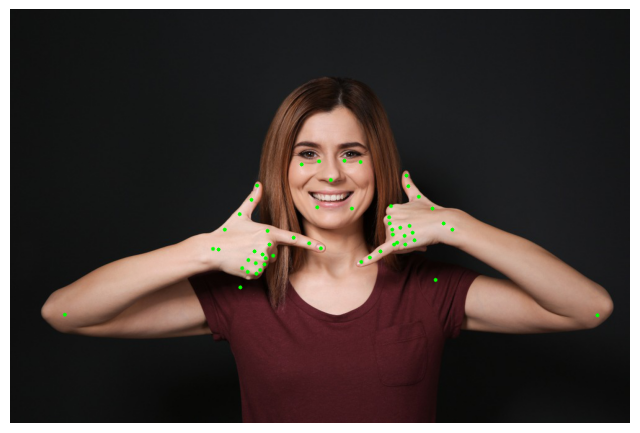

In [35]:
height, width, _ = img.shape

frame_landmarks = get_frame_landmarks(img[:,:,::-1])

for landmark in frame_landmarks:
    x = int(landmark[0] * width)
    y = int(landmark[1] * height)
    cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

## Data Encoding (done once!)

For each video, find the video landmarks and save as a numpy file

Then, use each numpy file to create a landmarks numpy array of all data (download link provided at end)

### Prepare Data

* From the full WLASL data, extract landmarks

In [38]:
# parse the JSON data and convert to Python data structure (list or dictionary)
with open(f'{base_path}/WLASL_parsed_data.json', 'r') as json_file:
    all_data = json.load(json_file)

In [39]:
len(all_data)

11980

### Example Video Landmarking

In [42]:
vid_index = 2000
vid_inst = all_data[vid_index]
vid_name = os.path.basename(vid_inst['video_path'])

video_landmarks = get_video_landmarks(vid_inst['video_path'],vid_inst['frame_start'],vid_inst['frame_end'])

print(np.shape(video_landmarks))

output_path = f'{base_path}/landmarks_{vid_name}'
draw_landmarks(vid_inst['video_path'], output_path, video_landmarks, vid_inst['frame_start'],vid_inst['frame_end'])

(59, 55, 2)


### Define and save landmarks for all videos
* Save a landmark numpy for each video
* Combine landmarks of each video into a dictionary 
 * key: an integer wrapped in a string, i.e. 'int', that corresponds to its position in WLASL_parsed_data.json
 * value: a (110, frames) numpy array

In [63]:
npy_dir = f'{base_path}/landmarks'
os.makedirs(npy_dir, exist_ok=True)

In [70]:
# For each video, its landmarks are extracted and stored in a .npy file
try:
    for i in tqdm(range(len(all_data)), ncols=100):
        npy_path = os.path.join(npy_dir, f'{i}.npy')
        if os.path.exists(npy_path): continue
        video_path = all_data[i]['video_path']
        start = all_data[i]['frame_start']
        end = all_data[i]['frame_end']
        
        try:
            video_landmarks = get_video_landmarks(video_path, start, end)
            np.save(npy_path, video_landmarks)
            
        except Exception as e:
            print(f"\nError encoding {video_path}\n{e}")
            continue   
        clear_output(wait=True)

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")

100%|███████████████████████████████████████████████████████| 11980/11980 [6:07:21<00:00,  1.84s/it]


In [69]:
landmarks_dict = {}

for filename in os.listdir(npy_dir):
    if filename.endswith('.npy'):
        key = filename.split('.')[0]
        landmarks = np.load(os.path.join(npy_dir, filename), allow_pickle=True)
        shape = landmarks.shape
        landmarks_reshaped = (landmarks.reshape((shape[0], shape[1] * shape[2]))).T
        landmarks_dict[key] = landmarks_reshaped # (landmarks=55 * (x,y) coordinates, frames)

np.savez(f'{base_path}/landmarks.npz', **landmarks_dict)

FileLink(rf'{base_path}/landmarks.npz')

/Users/renabi/Academia/2024 Spring/Computer Vision/asl_cv/wlasl/landmarks.npz

### Loading Data

* Load in relevant parsed data from video preprocess ipynb
  * Landmarks: the landmarks for each video
  * Data: metadata of video instances
  * Parsed json (WLASL100 in this case for videos of top 100 glosses)
* Split data into train, test, and val sets

In [43]:
landmarks_dict = np.load(f'{base_path}/landmarks.npz', allow_pickle=True)

with open(f'{base_path}/WLASL100_parsed_data.json', 'r') as json_file:
    data = json.load(json_file)
len(data)

1013

In [44]:
print(np.shape(landmarks_dict['3'])) # (landmarks=55 * (x,y) coordinates, frames)
data[int('3')] # the metadata for one video instance


(110, 86)


{'gloss': 'book',
 'label': 0,
 'video_path': 'wlasl/videos100/07070.mp4',
 'frame_start': 1,
 'frame_end': -1,
 'split': 'train'}

In [45]:
'''
A function to load in the data into a split
Params:
  split: a string representing 'train', 'test', or 'val' corresponding to the set
  labels_dict: a dictionary of labels to integers representing a gloss and its numerical class
  landmarks_dict: a dictionary of string keys to a numpy array representing a video instance and its landmarks
Returns:
  a (# videos, # frames, 55 landmarks, (x,y) coordinates) numpy array of the landmarks for each video
  a (# videos,) numpy array of integers representing the class of each video
'''

def load_data(split, data=None, lmarks_dict=landmarks_dict):

  indices = range(len(data))

  X = [lmarks_dict[f'{i}'][:,:].tolist() for i in indices if data[i]['split'] == split]
  Y = [data[i]['label'] for i in indices if data[i]['split'] == split]

  return X, Y

In [46]:
# Creating the training, testing, validation dataset
X_train, Y_train = load_data('train', data)
X_val, Y_val = load_data('val', data)
X_test, Y_test = load_data('test', data)

In [49]:
print("# videos in train set: ", len(X_train))
print("# videos in test set: ", len(X_test))
print("# videos in val set: ", len(X_val))

# videos in train set:  748
# videos in test set:  100
# videos in val set:  165


In [77]:
instance = 1 # video instance index

print(len(X_train[instance])) # number features (55*2 landmarks)
print(len(X_train[instance][0])) # number frames for feature 0
print(len(X_train[instance][1])) # number frames for feature 1


110
30
30


In [48]:
print("# unique labels in train set: ", len(np.unique(Y_train)))
print("# unique labels in test set: ", len(np.unique(Y_test)))
print("# unique labels in val set: ", len(np.unique(Y_val)))

# unique labels in train set:  100
# unique labels in test set:  72
# unique labels in val set:  89


### Write Data to File For Future Models

* Want to define train, test, val sets that are of shape (videos, 55*2 + 1, frames)
  * 55*2 for landmarks, 1 for the label

In [70]:
import pickle 

# import the names of the landmarks
with open(f'{base_path}/mpipe_lmarks.pkl', 'rb') as f:
    lmark_names = pickle.load(f)

len(lmark_names)

110

In [71]:
import csv

'''
A function to write provided X and Y arrays and header names to a csv file of (rows, columns)
Params:
  path: a str representing the path to write the file to
  X: a (rows, columns-1) shape list
  Y: a (rows) shape list
  X_head: a (columns-1) shape list of str
  Y_head: a str of of the name of the Y values
'''
def write_data(path, X, Y, X_head, Y_head):
  assert len(X) == len(Y), "write error: X and Y are not equal length"
  with open(f'{path}', 'w') as file:
    writer = csv.writer(file)
    header = X_head + [Y_head]
    writer.writerow(header)
    for (x,y) in zip(X,Y):
      writer.writerow(x + [y])


In [73]:
X_head = list(lmark_names.values())
Y_head = 'label'

In [74]:
write_data(f'{base_path}/train.csv', X_train, Y_train, X_head, Y_head)
write_data(f'{base_path}/test.csv', X_test, Y_test, X_head, Y_head)
write_data(f'{base_path}/val.csv', X_val, Y_val, X_head, Y_head)
